# Ex 9-2: Stock Prediction

- 주가 예측 모델을 만드는 것이 목표 
- 5일 간의 open, high, low, close, volume, change 값을 사용하여 그 다음날 close 값을 예측


In [1]:
#!pip install finance-datareader

In [1]:
from keras.models import Sequential, load_model
from keras import layers
from keras import backend as K
from keras import optimizers
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import FinanceDataReader as fdr


Using TensorFlow backend.


## Data 준비

### Data 불러오기

- 원하는 주식 종목을 선택하여 데이터를 불러옴 

In [2]:
df_krx = fdr.StockListing('KRX')  # 코스피, 코스닥, 코넥스 전체
df_krx
# https://github.com/FinanceData/FinanceDataReader

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,특수 목적용 기계 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"이현우, 박대현",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도
...,...,...,...,...,...,...,...,...,...,...
7251,000547,KOSPI,흥국화재2우B,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7252,000545,KOSPI,흥국화재우,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7253,003280,KOSPI,흥아해운,해상 운송업,외항화물운송업(케미컬탱커),1976-06-29,12월,이환구,http://www.heung-a.com,서울특별시
7254,037440,KOSDAQ,희림,"건축기술, 엔지니어링 및 관련 기술 서비스업",설계 및 감리용역,2000-02-03,12월,"정영균, 이목운, 허철호 (각자대표)",http://www.heerim.com,서울특별시


In [22]:
df_krx[df_krx['Name'].str.contains("삼성전자")]

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
167,58F739,KOSPI,KBF739삼성전자콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
171,58F935,KOSPI,KBF935삼성전자콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
172,58F937,KOSPI,KBF937삼성전자콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
176,58FA83,KOSPI,KBFA83삼성전자콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
179,58FA86,KOSPI,KBFA86삼성전자콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6804,57GA13,KOSPI,한국GA13삼성전자콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6805,57GA14,KOSPI,한국GA14삼성전자콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6916,57GB25,KOSPI,한국GB25삼성전자풋,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6917,57GB26,KOSPI,한국GB26삼성전자풋,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [4]:
df = fdr.DataReader('005930', '2000')
print(df.shape)
df = df.dropna()
print(df.shape)

(5248, 6)
(5248, 6)


In [6]:
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-03-31,82400,82700,81400,81400,17240518,-0.009732
2021-04-01,82500,83000,82000,82900,18676461,0.018428
2021-04-02,84000,85200,83900,84800,22997538,0.022919
2021-04-05,85800,86000,84800,85400,16255990,0.007075
2021-04-06,86200,86200,85100,86000,18883288,0.007026


### Scaling data

<font color=blue>

TO DO: MinMaxScaler를 사용해 x와 y의 scaling 진행 http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html <br>
    x와 y의 scaler를 따로 생성하여 예측된 y를 inverse scaling 하는데 사용 <br>

- x: 'Close'를 포함한 모든 column <br>
- y: 'Close'

In [7]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x = scaler_x.fit_transform(df)
y = scaler_y.fit_transform(df.iloc[:,[3]]) 

Text(0, 0.5, 'Close')

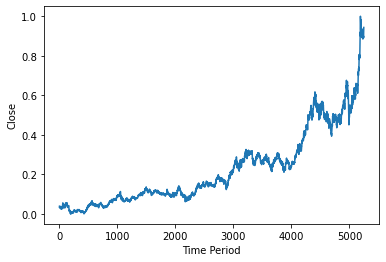

In [8]:
plt.plot(y)
plt.xlabel("Time Period")
plt.ylabel("Close")

### Construct input and output sequences

<font color=blue>
    
 TO DO: Input과 output sequence 만들기 

- `# Example 9-1:  RNN - Toy Example`의 "Construct training instances" 참고
- dataX: 5일 간 6개 변수 값. 
- dataY: 다음 날 close 값.

In [9]:
SEQ_LEN = 5

In [10]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - SEQ_LEN):
    _x = x[i:i + SEQ_LEN ]
    _y = y[i + SEQ_LEN]  
    dataX.append(_x)
    dataY.append(_y)

In [11]:
np.shape(dataX), np.shape(dataY)

((5243, 5, 6), (5243, 1))

#### Train/test split

In [12]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
Xtrain, Xtest = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
ytrain, ytest = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

- 가장 최근 30%  자료를 test set으로 분리 

In [13]:
np.shape(Xtrain), np.shape(Xtest)

((3670, 5, 6), (1573, 5, 6))

## Model building

<font color=blue> 

TO DO: LSTM, Dense, Dropout 등을 사용하여 model 만들고 compile하여 확인.


In [14]:
model = Sequential()

model.add(layers.LSTM(32, input_shape = (SEQ_LEN, 6), return_sequences = True, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32, return_sequences = False, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))

model.compile(loss='mse',optimizer='adam')


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             4992      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 14,401
Trainable params: 14,401
Non-trainable params: 0
__________________________________________________

## Model fitting and checking with Tensorboard

<font color=blue>

TO DO: 위에서 생성한 model을 training. 

- Tensorboard를 통해 training과 validation loss 확인
- Validation loss 기준 best model을 저장

In [16]:
#now = time.strftime("%c")
now = time.strftime('%Y-%m-%d', time.localtime(time.time()))
callbacks_list = [
    TensorBoard(log_dir = 'logs/stock_prediction/node33'+now, histogram_freq = 0, write_graph = True),
    #TensorBoard(log_dir = 'logs/stock_prediction1/', histogram_freq=1, embeddings_freq=1,
                # histogram_freq=1 : 1 에포크마다 활성화 출력의 히스토그램을 기록
                # embeddings_freq=1 : 1에포크 마다 임베딩 데이터 기록
                # profile_batch : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
               #profile_batch=100000000),
    ModelCheckpoint(filepath="logs/stock_prediction_node33.h5", monitor='val_loss', verbose=0, save_best_only=True)
]

model.fit(Xtrain, ytrain, 
          batch_size = 128, 
          epochs = 50, 
          validation_split = 0.3, 
          callbacks = callbacks_list)

Train on 2569 samples, validate on 1101 samples
Epoch 1/50
2048/2569 [======================>.......] - ETA: 0s - loss: 0.0033

C:\Users\028\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:92: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165164). Check your callbacks.
  warnings.warn(


2569/2569 [==============================] - 1s 492us/step - loss: 0.0030 - val_loss: 0.0212
Epoch 2/50
2569/2569 [==============================] - 0s 61us/step - loss: 0.0013 - val_loss: 0.0190
Epoch 3/50
2569/2569 [==============================] - 0s 64us/step - loss: 8.6667e-04 - val_loss: 0.0120
Epoch 4/50
2569/2569 [==============================] - 0s 69us/step - loss: 3.2920e-04 - val_loss: 0.0044
Epoch 5/50
2569/2569 [==============================] - 0s 62us/step - loss: 1.8098e-04 - val_loss: 0.0032
Epoch 6/50
2569/2569 [==============================] - 0s 71us/step - loss: 1.2856e-04 - val_loss: 0.0028
Epoch 7/50
2569/2569 [==============================] - 0s 77us/step - loss: 1.2195e-04 - val_loss: 0.0027
Epoch 8/50
2569/2569 [==============================] - 0s 66us/step - loss: 1.1146e-04 - val_loss: 0.0026
Epoch 9/50
2569/2569 [==============================] - 0s 64us/step - loss: 1.0320e-04 - val_loss: 0.0021
Epoch 10/50
2569/2569 [==============================] 

## Prediction

In [17]:
model = load_model('logs/stock_prediction_node33.h5')
test_predict = model.predict(Xtest)
test_predict_back = scaler_y.inverse_transform(test_predict)
ytest_back = scaler_y.inverse_transform(ytest)

- output 값을 original scale로 재변환

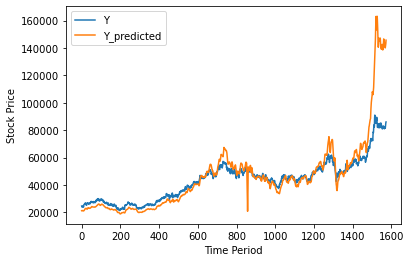

In [18]:
# Plot predictions
plt.plot(ytest_back, label = 'Y')
plt.plot(test_predict_back, label = 'Y_predicted')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [19]:
mean_absolute_error(test_predict_back, ytest_back), np.mean(test_predict_back / ytest_back) - 1
# mean_absolute_error 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화 
# 참고 https://mizykk.tistory.com/102

(6087.013933864431, 0.002138640412162607)